In [144]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import normflows as nf
from tqdm import tqdm

def uniform_prior(lb, ub, shape):
    return torch.rand(shape) * (ub - lb) + lb 

def normal_prior(mean, scale, shape):
    return torch.randn(shape) * scale + mean

def forward_simulation(thetas, samples_per_theta):
    
    singleton = False
    if len(thetas.shape) == 1:
        singleton = True 
        thetas = thetas[None].clone()
    
    z = torch.randn(thetas.shape[0], samples_per_theta, thetas.shape[1])
    
    component = (torch.rand(thetas.shape[0], samples_per_theta) > 0.5)[:, :, None]
    scale = 0.99 * component + 0.01 
    
    samples = z * scale + thetas[:, None].repeat(1, samples_per_theta, 1)
    if singleton:
        return samples[0]
    else:
        return samples
    
def get_hpd_set(
    model: nf.ConditionalNormalizingFlow,
    param_grid: torch.Tensor,
    confidence_level: float,
    context: torch.Tensor,
):
    model.eval()
    with torch.no_grad():
        log_probs = model.log_prob(param_grid, context.repeat(param_grid.shape[0], 1))
        prob_scale_factor = 1/torch.exp(log_probs).sum()
        rescaled_probs = torch.exp(log_probs) * prob_scale_factor

    sorted_probs = torch.sort(rescaled_probs, descending=True).values
    cut_index = (torch.cumsum(sorted_probs, dim=0)/rescaled_probs.sum() < confidence_level).sum()
    prob_critical = sorted_probs[cut_index]
    
    return param_grid[rescaled_probs >= prob_critical], torch.log(prob_critical/prob_scale_factor)

def get_waldo_set(
    model: nf.ConditionalNormalizingFlow,
    param_grid: torch.Tensor,
    qr,
    context: torch.Tensor,
):
    model.eval()
    _, _, ts_over_grid = fast_waldo_evaluate(
        model,
        param_grid,
        context[None],
        1_000
    )
    
    crit_values_over_grid = qr.predict(param_grid.numpy())
    assert ts_over_grid.shape == crit_values_over_grid.shape 
    
    mask = ts_over_grid.cpu().numpy() <= crit_values_over_grid

    
    return ts_over_grid, crit_values_over_grid, param_grid[mask]

def waldo_evaluate(
    model: nf.ConditionalNormalizingFlow,
    parameter: torch.Tensor ,
    context: torch.Tensor,
    num_samples: int
):
    model.eval()
    with torch.no_grad():
        samples, _ = model.sample(num_samples, context[None].expand(num_samples, 2))
        mean = samples.mean(dim=0)
        mean_diff = parameter - mean
        cov = torch.cov(torch.transpose(samples, 1, 0))
        return mean_diff, cov, (torch.matmul(mean_diff, torch.linalg.inv(cov)) * mean_diff).sum()
    
def _batch_cov(points: torch.Tensor):
    B, N, D = points.size()
    mean = points.mean(dim=1).unsqueeze(1)
    diffs = (points - mean).reshape(B * N, D)
    prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(B, N, D, D)
    bcov = prods.sum(dim=1) / (N - 1)  # Unbiased estimate
    return bcov  # (B, D, D)
    
def fast_waldo_evaluate(
    model: nf.ConditionalNormalizingFlow,
    theta_batch: torch.Tensor,
    context_batch: torch.Tensor,
    posterior_samples_per_obs: int
):
    assert len(theta_batch.shape) == 2
    assert len(context_batch.shape) == 2
    model.eval()
    with torch.no_grad():

        samples, _ = model.sample(
            posterior_samples_per_obs * context_batch.shape[0], 
            context_batch[:, None].repeat(1, posterior_samples_per_obs, 1).view(-1, context_batch.shape[-1])
        )
        samples = samples.view(context_batch.shape[0], posterior_samples_per_obs, -1)
        posterior_diffs = samples.mean(dim=1) - theta_batch.to(model.device) # shape N, D
        posterior_variances = _batch_cov(samples) # shape N, D, D
        step1 = torch.matmul(posterior_diffs[:, None], torch.linalg.inv(posterior_variances)).squeeze(1) # shape N, D
        waldos = (step1 * posterior_diffs).sum(dim=1)
        
        return posterior_diffs, posterior_variances, waldos
    
def pd_evaluate(
    model: nf.ConditionalNormalizingFlow,
    theta_batch: torch.Tensor,
    context_batch: torch.Tensor,
    posterior_samples_per_obs: int
):
    samples, _ = model.sample(
        posterior_samples_per_obs * context_batch.shape[0], 
        context_batch[:, None].repeat(1, posterior_samples_per_obs, 1).view(-1, context_batch.shape[-1])
    )
    samples = samples.view(context_batch.shape[0], posterior_samples_per_obs, -1)
    pairwise = torch.cdist(samples, samples).view(context_batch.shape[0], -1)
    
    
        

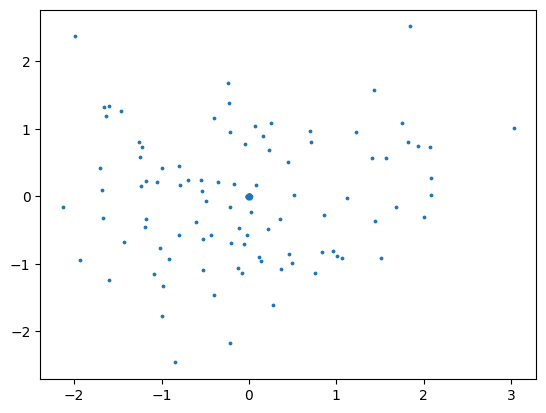

In [5]:
test_theta = torch.tensor([0, 0])
samples = forward_simulation(test_theta, 200)
plt.scatter(samples[:, 0], samples[:, 1], s=3)

In [1]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, thetas, obs):
        self.thetas = thetas 
        self.obs = obs 
        
    def __len__(self):
        return self.thetas.shape[0]
    
    def __getitem__(self, idx):
        return {
            "thetas": self.thetas[idx],
            "obs": self.obs[idx]
        }
    
DEVICE = torch.device("cuda:0")
# MAF ------------------------------------------------------
num_flows = 4
latent_size = 2 
hidden_units = 128
num_blocks = 2

flows = []
for _ in range(num_flows):
    flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
                                                context_features=2, 
                                                num_blocks=num_blocks)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
    
# Construct flow model
maf_model = nf.ConditionalNormalizingFlow(q0, flows)
maf_model.to(DEVICE)
maf_model.device = DEVICE

train_n = 100_000
val_n = 20_000
cal_n = 10_000
poi_dim = 2
train_thetas = normal_prior(0, 1, (train_n, poi_dim))
train_obs = forward_simulation(train_thetas, 1).view(-1, poi_dim)

val_thetas = normal_prior(0, 1, (val_n, poi_dim))
val_obs = forward_simulation(val_thetas, 1).view(-1, poi_dim)

cal_thetas = uniform_prior(-6, 6, (cal_n, poi_dim))
cal_obs = forward_simulation(cal_thetas, 1).view(-1, poi_dim)

train_ds = SimpleDataset(
    train_thetas,
    train_obs
)

val_ds = SimpleDataset(
    val_thetas,
    val_obs
)

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=1024,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=1024,
    shuffle=True
)

NameError: name 'torch' is not defined

In [27]:
opt = torch.optim.Adam(maf_model.parameters(), 1e-7)
maf_model.to(DEVICE)
maf_model.train()
best_val_loss = 99999999

for _ in tqdm(range(200), desc="Training Epochs"):
    for batch in train_loader:
        opt.zero_grad()
        loss = maf_model.forward_kld(batch['thetas'].to(DEVICE), batch['obs'].to(DEVICE))
        loss.backward()
        opt.step()
    
    maf_model.eval()
    total_train_loss = 0
    total_val_loss = 0
    with torch.no_grad():
        for batch in train_loader:
            loss = maf_model.forward_kld(batch['thetas'].to(DEVICE), batch['obs'].to(DEVICE)).item() * batch['thetas'].shape[0]
            total_train_loss += loss 
        for batch in val_loader:
            loss = maf_model.forward_kld(batch['thetas'].to(DEVICE), batch['obs'].to(DEVICE)).item() * batch['thetas'].shape[0]
            total_val_loss += loss 
            
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(maf_model.state_dict(), "temp.pt")
    print(f"Train Loss {total_train_loss/train_n:0.4f} | Val Loss {total_val_loss/val_n:0.4f}")
    
maf_model.load_state_dict(torch.load("temp.pt"))
            
    

KeyboardInterrupt: 

In [129]:
maf_model.load_state_dict(torch.load("temp.pt"))
maf_model.to(DEVICE)

hpd_set, _ = get_hpd_set(
    maf_model,
    torch.cartesian_prod(
        torch.linspace(-3, 3, 200),
        torch.linspace(-3, 3, 200)
    ).to(DEVICE),
    0.9,
    torch.tensor([1., 1.]).to(DEVICE)
)
hpd_set = hpd_set.cpu()

In [115]:
waldo_evaluate(maf_model, torch.tensor([0., 0.], device=DEVICE), torch.tensor([1., 1.], device=DEVICE), 10_000)

(tensor([-0.7339, -0.7645], device='cuda:0'),
 tensor([[ 1.4849, -0.5294],
         [-0.5294,  0.6371]], device='cuda:0'),
 tensor(2.7114, device='cuda:0'))

In [127]:
fast_waldo_evaluate(maf_model, torch.tensor([[0., 0.]], device=DEVICE), torch.tensor([[1., 1.]], device=DEVICE), 10_000)


(tensor([[0.7323, 0.7610]], device='cuda:0'),
 tensor([[[ 1.3906, -0.4930],
          [-0.4930,  0.6212]]], device='cuda:0'),
 tensor([2.7187], device='cuda:0'))

In [122]:
batch_size = 32
cal_waldos = np.zeros(cal_n)
i = 0
with tqdm(total=cal_thetas.shape[0], desc="Cal TS") as pbar:
    while i < cal_thetas.shape[0]:
        _, _, waldos = fast_waldo_evaluate(
            maf_model,
            cal_thetas[i:i+batch_size].to(DEVICE),
            cal_obs[i:i+batch_size].to(DEVICE),
            10_000,
            DEVICE
        )
        cal_waldos[i:i+batch_size] = waldos.cpu()
        i += batch_size
        pbar.update(batch_size)

Cal TS: 10016it [00:19, 508.65it/s]                          


In [123]:
from lf2i.calibration.critical_values import train_qr_algorithm

qr = train_qr_algorithm(
            test_statistics=cal_waldos,
            parameters=cal_thetas,
            algorithm='cat-gb',
            alpha=0.9,  # acceptance region on the left
            param_dim=2,
            algorithm_kwargs={
                # 'cv': {
                #     'n_estimators': [100, 300, 500],
                #     'max_depth': [1, 3, 5]
                #     # 'n_estimators': [100],
                #     # 'max_depth': [1]
                # }
                'n_estimators': 500,
                'max_depth': 5
            }
        )

0:	learn: 1.2825685	total: 6.4ms	remaining: 3.19s
1:	learn: 1.2497079	total: 11.4ms	remaining: 2.85s
2:	learn: 1.2204320	total: 16ms	remaining: 2.65s
3:	learn: 1.1936163	total: 20.1ms	remaining: 2.49s
4:	learn: 1.1668194	total: 24.3ms	remaining: 2.41s
5:	learn: 1.1396743	total: 29.2ms	remaining: 2.4s
6:	learn: 1.1143213	total: 32.9ms	remaining: 2.31s
7:	learn: 1.0905321	total: 36.9ms	remaining: 2.27s
8:	learn: 1.0688852	total: 41.3ms	remaining: 2.25s
9:	learn: 1.0469353	total: 44.4ms	remaining: 2.18s
10:	learn: 1.0271463	total: 47.9ms	remaining: 2.13s
11:	learn: 1.0069977	total: 52.1ms	remaining: 2.12s
12:	learn: 0.9878895	total: 55.6ms	remaining: 2.08s
13:	learn: 0.9710357	total: 59.1ms	remaining: 2.05s
14:	learn: 0.9562596	total: 62.2ms	remaining: 2.01s
15:	learn: 0.9386016	total: 65.7ms	remaining: 1.99s
16:	learn: 0.9238102	total: 69.3ms	remaining: 1.97s
17:	learn: 0.9078297	total: 72.3ms	remaining: 1.94s
18:	learn: 0.8943462	total: 76.3ms	remaining: 1.93s
19:	learn: 0.8803724	total

In [132]:
torch.cartesian_prod(
        torch.linspace(-3, 3, 200),
        torch.linspace(-3, 3, 200)
    ).shape

torch.Size([40000, 2])

In [151]:
hpd_set, _ = get_hpd_set(
    maf_model,
    torch.cartesian_prod(
        torch.linspace(-3, 3, 200),
        torch.linspace(-3, 3, 200)
    ).to(DEVICE),
    0.9,
    torch.tensor([1., 1.]).to(DEVICE)
)
hpd_set = hpd_set.cpu()

_, _, waldo_set = get_waldo_set(
    maf_model,
    torch.cartesian_prod(
        torch.linspace(-3, 3, 200),
        torch.linspace(-3, 3, 200)
    ),
    qr, 
    torch.tensor([1., 1.]).to(DEVICE)
)

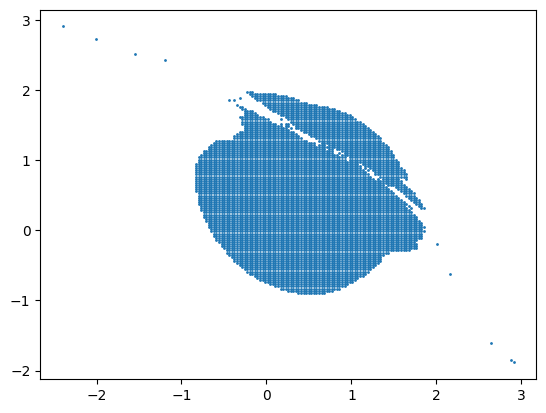

In [149]:
fig, ax = plt.subplots()
ax.scatter(hpd_set[:, 0], hpd_set[:, 1], s=1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

(-3.0, 3.0)

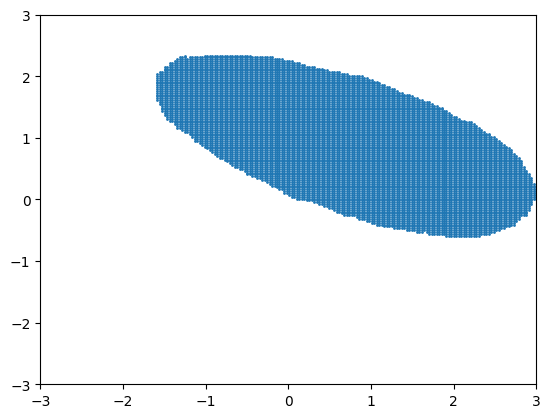

In [153]:
fig, ax = plt.subplots()
ax.scatter(waldo_set[:, 0], waldo_set[:, 1], s=1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

In [175]:
with torch.no_grad():
    context_batch = torch.tensor([[0., 0.]]).to(DEVICE)
    samples, _ = maf_model.sample(
        1_000 * context_batch.shape[0], 
        context_batch[:, None].repeat(1, 1_000, 1).view(-1, context_batch.shape[-1])
    )
    torch.quantile(torch.cdist(samples, samples), 0.9)

In [176]:
torch.(torch.cdist(samples, samples), 0.9)

tensor(1.7492, device='cuda:0')

In [165]:
samples.shape

torch.Size([10000, 2])

In [159]:
test1 = torch.randn(2, 10, 3)
test2 = torch.randn(2, 10, 3)
torch.cdist(test1, test2).shape

torch.Size([2, 10, 10])

# SBI test

In [1]:
import pickle as pkl
import tiled_events as te
import configs 
import cr_sources as crs
import numpy as np
import torch
from tqdm import tqdm

config = configs.FULL_PRIORS_RESTRICT_AZIMUTH_UNIFORM_TEST_LIMIT_CAL_NO_SHIFT

with open("../vsi_splits_flexible_priors_uniform_test/val.pkl", "rb") as file:
    event_list = pkl.load(file)
    
train_trajectory = crs.get_source_trajectory(config.train_astropy_source_name, config.train_observer_latitude)
train_min_zenith = np.deg2rad(90 - np.array(train_trajectory.alt).max())

if train_min_zenith > 0:
    print(f"Minimum Zenith: {train_min_zenith:0.5f}")
    event_list = [e for e in tqdm(event_list, desc="Zenith Chop") if e.zenith >= train_min_zenith]
    
train_ds = te.CRImageDataset(
    events=event_list,
    downsample_factor=config.downsample_factor,
    detector_layout=config.detector_layout,
    max_shift_radius=config.max_shift_radius,
    min_nonzero_features=config.min_features_threshold,
    # device=torch.device("cuda:1"),
    device=torch.device("cpu"),
    sample_ratio=config.train_sample_ratio,
    restrict_to_pm90=config.restrict_azimuth_to_pm90deg,
    no_azimuth=config.no_azimuth
)

with open("../results/full_priors_restrict_azimuth_uniform_test_limit_cal_no_shift_0/train_feature_maxes.pkl", 'rb') as file:
    train_feature_maxes = pkl.load(file)
train_ds.set_feature_scale(train_feature_maxes)
train_ds.set_param_weighter(-1)

2024-11-07 18:21:13.386479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 18:21:13.386554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 18:21:13.388521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 18:21:13.397818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 18:21:15.267385: W tensorflow/compiler/tf2

Minimum Zenith: 0.64632


Sparse Grid Features: 100%|██████████| 17313/17313 [00:06<00:00, 2589.75it/s]


Parameter Weighter set to -1


In [4]:
with open("single_event.pkl", "wb") as file:
    pkl.dump(train_ds[0], file)
train_ds[0]['features'].shape

torch.Size([3, 100, 100])

In [3]:
params = list()
features = list()
limit = 1000
for i in tqdm(range(len(train_ds))):
    event = train_ds[i]
    if event is None:
        continue
    params.append(event['params'])
    features.append(event['features'])
    limit -= 1
    if limit <= 0:
        break
params = torch.stack(params)
features = torch.stack(features)
del train_ds

  6%|▌         | 1023/17313 [00:10<02:54, 93.62it/s]


In [3]:
from sbi.inference.trainers.npse import NPSE
from torch import Tensor
from typing import Callable, Optional, Any
class WeightedNPSE(NPSE):
    def _loss(
        self,
        theta: Tensor,
        x: Tensor,
        masks: Tensor,
        proposal: Optional[Any],
        calibration_kernel: Callable,
        force_first_round_loss: bool = False,
    ) -> Tensor:
        """Return loss from score estimator. Currently only single-round NPSE
         is implemented, i.e., no proposal correction is applied for later rounds.

        The loss is the negative log prob. Irrespective of the round or SNPE method
        (A, B, or C), it can be weighted with a calibration kernel.

        Returns:
            Calibration kernel-weighted negative log prob.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
        """
        if self._round == 0 or force_first_round_loss:
            # First round loss.
            loss = self._neural_net.loss(theta, x)
        else:
            raise NotImplementedError(
                "Multi-round NPSE with arbitrary proposals is not implemented"
            )

        return calibration_kernel(theta) * loss

In [4]:
# from sbi.neural_nets.estimators.score_estimator import VPScoreEstimator
from sbi.inference.trainers.npse import NPSE
from sbi.neural_nets.estimators.score_estimator import VPScoreEstimator, VEScoreEstimator
from sklearn.preprocessing import StandardScaler
import nde_models


npse = WeightedNPSE(
    score_estimator=lambda x, y: VPScoreEstimator(
        net = nde_models.ScoreModel(
            torch.device("cuda:0"),
            len(config.time_averages),
            torch.tensor(config.detector_layout.shape)/config.downsample_factor,
            13,
            1,
            3
        ),
        input_shape=torch.Size([3]),
        condition_shape=torch.Size([3, 100, 100])
    ),
    device="cuda:0"
)

# scaler = StandardScaler()
# scaler.fit(params.cpu())
# npse.append_simulations(torch.tensor(scaler.transform(params.cpu()), device=params.device, dtype=torch.float32), features)
npse.append_simulations(params, features)

/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/inference/trainers/npse/npse.py:144: UserWarning: Data x has device 'cuda:1'. Moving x to the data_device 'cuda:0'. Training will proceed on device 'cuda:0'.
  theta, x = validate_theta_and_x(
/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/inference/trainers/npse/npse.py:144: UserWarning: Parameters theta has device 'cuda:1'. Moving theta to the data_device 'cuda:0'. Training will proceed on device 'cuda:0'.
  theta, x = validate_theta_and_x(


In [5]:
npse.train(
    show_train_summary=True,
    # ema_loss_decay=1.0
)

 Neural network successfully converged after 652 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 652
        Best validation performance: 38.6917
        -------------------------
        


VPScoreEstimator(
  (net): ScoreModel(
    (relu): ReLU()
    (conv1): Conv2d(3, 8, kernel_size=(13, 13), stride=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(13, 13), stride=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=68, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=3, bias=True)
  )
)

Text(0, 0.5, 'Loss')

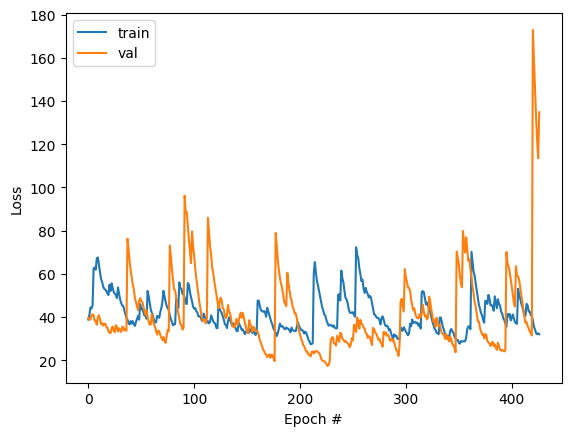

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(npse._summary["training_loss"], label="train")
ax.plot(npse._summary["validation_loss"], label="val")
ax.legend()
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss")

In [7]:
post = npse.build_posterior(sample_with="sde")

In [10]:
param_grid = torch.cartesian_prod(
    *[torch.linspace(mini, maxi, 20) for mini, maxi in zip(config.eval_param_mins, config.eval_param_maxes)]
)
scaled_param_grid = torch.cartesian_prod(*([torch.linspace(0, 1, 20)] * 3))

In [76]:
single_posterior = torch.exp(post.log_prob(theta=param_grid, x=features[1]))

/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 3 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


In [77]:
x_dist = torch.cdist(scaled_param_grid, scaled_param_grid)
d_dist = torch.cdist(single_posterior[:, None], single_posterior[:, None]).cpu()
L = (torch.nan_to_num(d_dist/x_dist, -99, -99, -99))
(L==L.max()).nonzero(), L.max()

(tensor([[1891, 1892],
         [1892, 1891]]),
 tensor(1155.5050))

In [79]:
param_grid[1891], param_grid[1892]

(tensor([3.6316, 1.0060, 0.2480]), tensor([3.6316, 1.0060, 0.4134]))

Text(0.5, 1.0, 'Posterior Slice at E=3.6316 and Z = 1.0060')

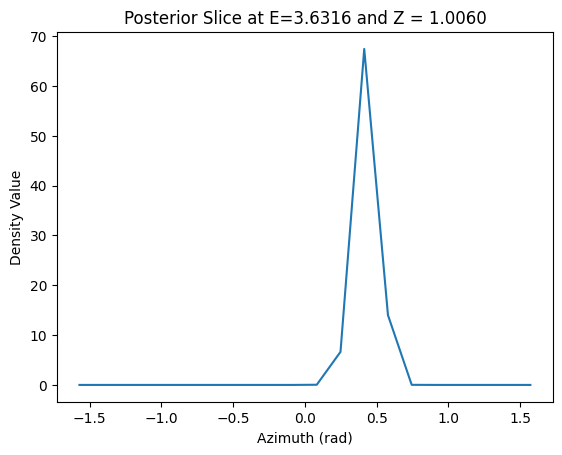

In [80]:
point_id = 1891
mask = (param_grid[:, 1] == param_grid[point_id, 1]) & (param_grid[:, 0] == param_grid[point_id, 0])
fig, ax = plt.subplots()
ax.plot(param_grid[mask][:, 2], single_posterior[mask].cpu())
ax.set_ylabel("Density Value")
ax.set_xlabel("Azimuth (rad)")
ax.set_title(f"Posterior Slice at E={param_grid[point_id, 0]:0.4f} and Z = {param_grid[point_id, 1]:0.4f}")

In [47]:
def min_mass(density_vals, L):
    return (0.25 * 4/3 * torch.pi * (density_vals/L)**3 * density_vals).sum()

min_mass(single_posterior, 1_000)

tensor(0.0640, device='cuda:0')

In [31]:
from zuko.utils import odeint
from zuko.transforms import FreeFormJacobianTransform

In [21]:
param_grid_gpu = param_grid.to(post._device)

In [52]:
flow = post.potential_fn.get_continuous_normalizing_flow(
    features[0:1],
)
with torch.no_grad():
    # flow.log_prob(param_grid_gpu)
    flow.transform.call_and_ladj(param_grid_gpu[:1000])
    # cProfile.run("flow.transform.call_and_ladj(param_grid_gpu[:1000])", 'profile_results')
# stats = pstats.Stats('profile_results')
# stats.sort_stats('time').print_stats()

In [44]:
param_grid[:1000].shape

torch.Size([1000, 3])

In [41]:


flow = post_cpu.potential_fn.get_continuous_normalizing_flow(
    features[0:1],
)
with torch.no_grad():
    # flow.log_prob(param_grid_gpu)
    # flow.transform.call_and_ladj(param_grid_gpu)
    cProfile.run("flow.transform.call_and_ladj(param_grid_gpu)", 'profile_results')
stats = pstats.Stats('profile_results')
stats.sort_stats('time').print_stats()

Mon Oct  7 04:11:15 2024    profile_results

         226112 function calls (211356 primitive calls) in 46.596 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       68   45.127    0.664   45.127    0.664 {method 'item' of 'torch._C.TensorBase' objects}
      476    0.379    0.001    0.379    0.001 {method 'run_backward' of 'torch._C._EngineBase' objects}
     1428    0.083    0.000    0.128    0.000 /home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/neural_nets/estimators/score_estimator.py:371(mean_t_fn)
      952    0.082    0.000    0.082    0.000 {built-in method torch.conv2d}
     5236    0.065    0.000    0.065    0.000 {method 'pow' of 'torch._C.TensorBase' objects}
     1428    0.065    0.000    0.129    0.000 /home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/neural_nets/estimators/score_estimator.py:387(std_fn)
      476    0.059    0.000    0.692    0.0

In [18]:
post.potential_fn.set_x(features[0:1])
post.potential_fn(
    param_grid.to(post._device),
    track_gradients=False
)

tensor([ -50.5735,  -44.9298,  -39.5016,  ..., -203.5949, -210.9982,
        -218.5811], device='cuda:0')

In [ ]:
import cProfile
import pstats
import os 
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
cProfile.run("single_posterior = torch.exp(post.log_prob(theta=param_grid, x=features[0:1]))", 'profile_results')
stats = pstats.Stats('profile_results')
stats.sort_stats('time').print_stats()

In [18]:
param_grid[::20]

tensor([[ 3.0000,  0.6463, -1.5708],
        [ 3.0000,  0.6720, -1.5708],
        [ 3.0000,  0.6977, -1.5708],
        ...,
        [ 6.0000,  1.0831, -1.5708],
        [ 6.0000,  1.1088, -1.5708],
        [ 6.0000,  1.1345, -1.5708]])

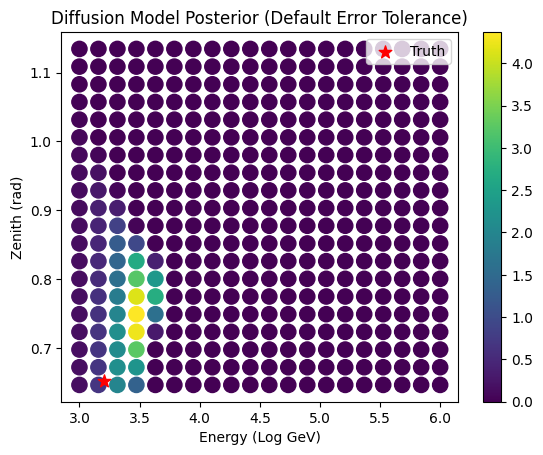

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
obs_index = 3
# single_posterior = torch.exp(post.log_prob(theta=param_grid, x=features[obs_index]))
pos = ax.scatter(param_grid[::20, 0], param_grid[::20, 1], c=single_posterior.view(20, 20, 20).mean(dim=-1).cpu(), s=120)
ax.scatter(params[obs_index, 0].cpu(), params[obs_index, 1].cpu(), marker="*", s=90, color="red", label="Truth")
ax.set_xlabel("Energy (Log GeV)")
ax.set_ylabel("Zenith (rad)")
ax.set_title("Diffusion Model Posterior (Default Error Tolerance)")
ax.legend()
fig.colorbar(pos)

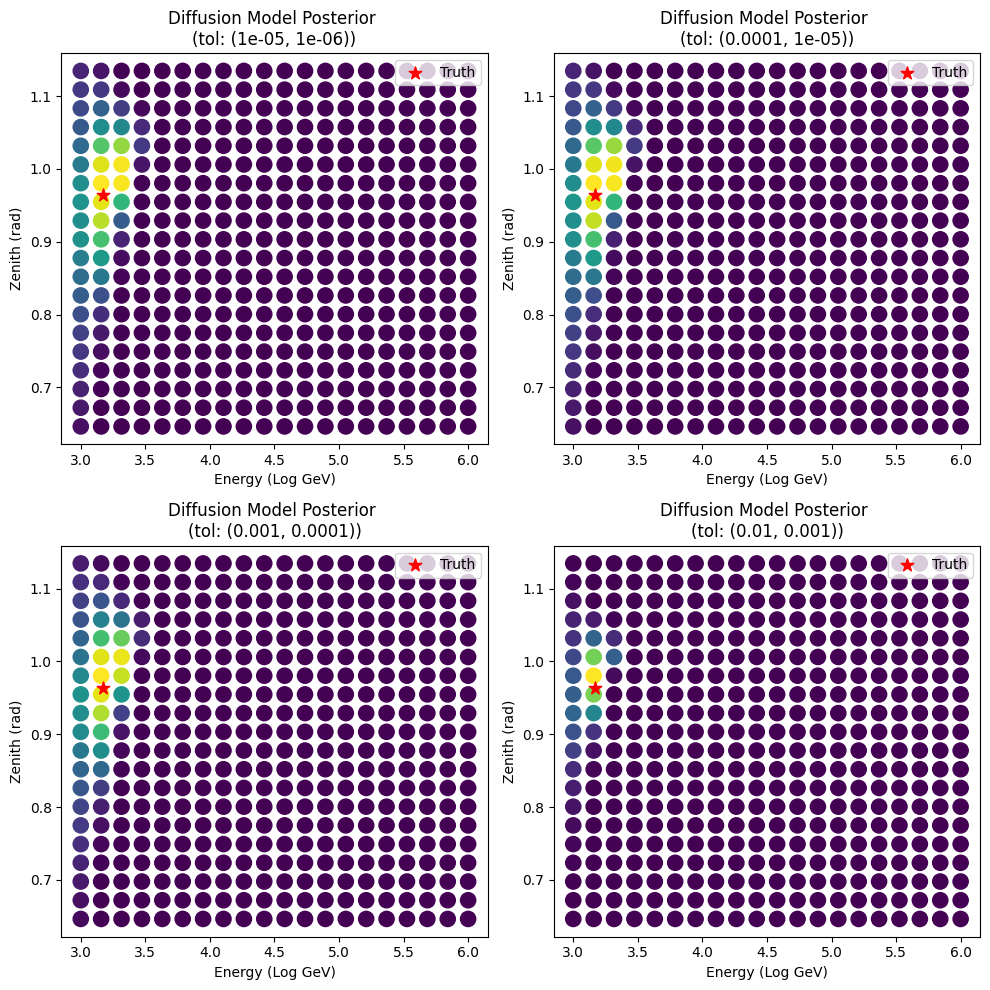

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
obs_index = 2
ax = ax.flatten()

tols = [(1e-5, 1e-6), (1e-4, 1e-5), (1e-3, 1e-4), (1e-2, 1e-3)]

for i, tol in enumerate(tols):
    single_posterior = torch.exp(post.log_prob(theta=param_grid, x=features[obs_index], atol=tol[0], rtol=tol[1]))
    ax[i].scatter(param_grid[::20, 0], param_grid[::20, 1], c=single_posterior.view(20, 20, 20).mean(dim=-1).cpu(), s=120)
    ax[i].scatter(params[obs_index, 0].cpu(), params[obs_index, 1].cpu(), marker="*", s=90, color="red", label="Truth")
    ax[i].set_xlabel("Energy (Log GeV)")
    ax[i].set_ylabel("Zenith (rad)")
    ax[i].set_title(f"Diffusion Model Posterior \n(tol: {tol})")
    ax[i].legend()
fig.tight_layout()

In [53]:
features.device

device(type='cuda', index=1)

In [ ]:
device = torch.device("cuda:0")
for _ in range(100):
    post.sample(torch.Size([10_000]), features[0].to(device), ts=torch.linspace(1, 0.0005, 10, device=device))

In [1]:
from lf2i.test_statistics import Waldo
import importlib
importlib.reload(nde_models)

waldo = Waldo(
    estimator=nde_models.SbiPosteriorLF2IWrapper(post, 3, features[0].device),
    poi_dim=3,
    estimation_method="posterior",
    num_posterior_samples=10_000,
    n_jobs=2
)

_ = waldo.evaluate(params[0:100].cpu(), features[0:100], mode="critical_values")

KeyboardInterrupt: 

In [41]:
waldo = Waldo(
    estimator=nde_models.SbiPosteriorLF2IWrapper(post, 3, features[0].device),
    poi_dim=3,
    estimation_method="posterior",
    num_posterior_samples=10_000,
    n_jobs=1
)

waldo.evaluate(params[0:100].cpu(), features[0:100], mode="critical_values")

Approximating conditional mean and covariance for 100 points...: 100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


array([0.01762625, 0.02521993, 0.04049381, 0.01685899, 0.00713493,
       0.00818209, 0.0249378 , 0.00982532, 0.01268718, 0.03180341,
       0.01518504, 0.03620065, 0.01416792, 0.03668146, 0.0061879 ,
       0.00528521, 0.01844676, 0.01636897, 0.01656192, 0.00686636,
       0.00749164, 0.01550107, 0.01876102, 0.0213022 , 0.01030992,
       0.01785835, 0.00156273, 0.02269317, 0.00492038, 0.02010894,
       0.00096097, 0.0068944 , 0.02293346, 0.02015173, 0.01858144,
       0.02076886, 0.0106116 , 0.00431472, 0.0307479 , 0.00660772,
       0.02205876, 0.02240215, 0.00425061, 0.01997205, 0.00972301,
       0.00810043, 0.02285703, 0.02629403, 0.0251578 , 0.04043185,
       0.02709456, 0.02554466, 0.02617309, 0.02863015, 0.02223806,
       0.0272676 , 0.02514979, 0.00719901, 0.00764367, 0.01147667,
       0.02138336, 0.01151894, 0.02129725, 0.00884453, 0.01556663,
       0.0075896 , 0.00997348, 0.02217555, 0.02184282, 0.02237711,
       0.02426363, 0.02799692, 0.01412557, 0.01974531, 0.03369

In [49]:
npse._neural_net.to(torch.device("cpu"))
npse._device = torch.device("cpu")
post_cpu = npse.build_posterior()
post_cpu._device = torch.device("cpu")

waldo = Waldo(
    estimator=nde_models.SbiPosteriorLF2IWrapper(post_cpu, 3, torch.device("cpu")),
    poi_dim=3,
    estimation_method="posterior",
    num_posterior_samples=10_000,
    n_jobs=1
)

waldo.evaluate(params[0:100].cpu(), features[0:100].cpu(), mode="critical_values")

NameError: name 'Waldo' is not defined

# Flow Matching

In [5]:
# from sbi.neural_nets.estimators.score_estimator import VPScoreEstimator
from sbi.inference.trainers.fmpe import FMPE
from sbi.neural_nets.net_builders.flowmatching_nets import build_resnet_flowmatcher, build_mlp_flowmatcher
from sbi.neural_nets.estimators.score_estimator import VPScoreEstimator, VEScoreEstimator
from sklearn.preprocessing import StandardScaler

from sbi.neural_nets.estimators.flowmatching_estimator import FlowMatchingEstimator
from sbi.neural_nets.net_builders.flowmatching_nets import VectorFieldMLP
from zuko.nn import MLP as ZukoMLP

import nde_models

context_model = nde_models.ContextModel(
    # device=torch.device("cuda:1"),
    device=torch.device("cuda:0"),
    num_channels=len(config.time_averages),
    final_grid_shape=torch.tensor(config.detector_layout.shape)/config.downsample_factor,
    context_size=256,
    kernel_size=13
)

context_model.eval()

net_builder = lambda theta, x: build_mlp_flowmatcher(
    theta,
    x,
    embedding_net=context_model,
    z_score_x=None,
    z_score_y=None
)



fmpe = FMPE(
    prior=None,
    density_estimator=net_builder,
    # device=torch.device("cuda:1"),
    device=torch.device("cuda:0"),
)

# scaler = StandardScaler()
# scaler.fit(params.cpu())
# npse.append_simulations(torch.tensor(scaler.transform(params.cpu()), device=params.device, dtype=torch.float32), features)
fmpe.append_simulations(params, features)

/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/inference/trainers/fmpe/fmpe.py:98: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda:0'. Training will proceed on device 'cuda:0'.
  theta, x = validate_theta_and_x(
/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/sbi/inference/trainers/fmpe/fmpe.py:98: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda:0'. Training will proceed on device 'cuda:0'.
  theta, x = validate_theta_and_x(


In [6]:
fmpe.train(
    show_train_summary=True
)

 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: 1.0695
        -------------------------
        


FlowMatchingEstimator(
  (net): VectorFieldMLP(
    (net): MLP(
      (0): Linear(in_features=265, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
      (10): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (_embedding_net): ContextModel(
    (relu): ReLU()
    (conv1): Conv2d(3, 8, kernel_size=(13, 13), stride=(1, 1))
    (maxpool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(13, 13), stride=(1, 1))
    (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=0, 

In [7]:
post = fmpe.build_posterior(
    prior=torch.distributions.Uniform(-99, 99)
)
param_grid = torch.cartesian_prod(
    *[torch.linspace(mini, maxi, 20) for mini, maxi in zip(config.eval_param_mins, config.eval_param_maxes)]
).to(torch.device("cuda:0"))



In [12]:
log_probs = torch.exp(post.log_prob(theta=param_grid, x=features[1][None].to("cuda:0"), norm_posterior=False))

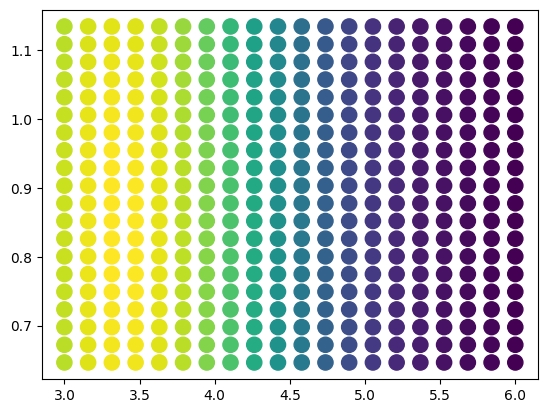

In [18]:
import matplotlib.pyplot as plt

plt.scatter(
    param_grid[::20, 0].cpu(),
    param_grid[::20, 1].cpu(),
    c=log_probs.view(20, 20, 20).mean(dim=-1).cpu(),
    s=120
)

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

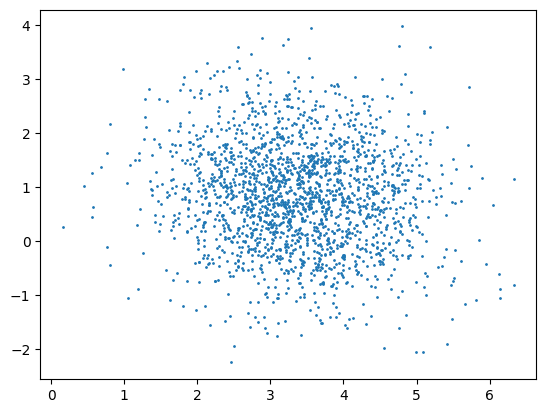

In [20]:
samples = post.sample([2000], x=features[1][None].to("cuda:0"))

plt.scatter(
    samples[:, 0].cpu(),
    samples[:, 1].cpu(),
    s=1
)